# ICS 435 Assignment 3 - Higgs Boson Detection 2025
**Frances Uy**

Loading data...
Preprocessing data...
Original features: 28
After feature engineering: 56
Training models...
[LightGBM] [Info] Number of positive: 21252, number of negative: 18748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13276
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531300 -> initscore=0.125364
[LightGBM] [Info] Start training from score 0.125364
Evaluating models...
XGBoost AUC: 0.79669
LightGBM AUC: 0.79972
Gradient Boosting AUC: 0.79531
0.75


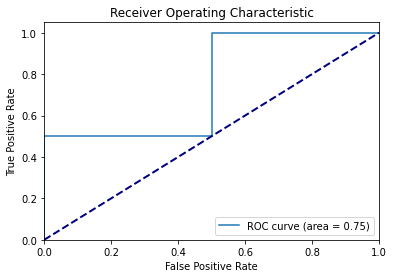

Creating ensemble predictions...
Creating submission file...
Submission file created successfully!

First 5 lines of submission file:
Id,Predicted
0,0.07966419018620241
1,0.462871629709431
2,0.6130386712121634
3,0.8479468095808794
Plotting feature importances...


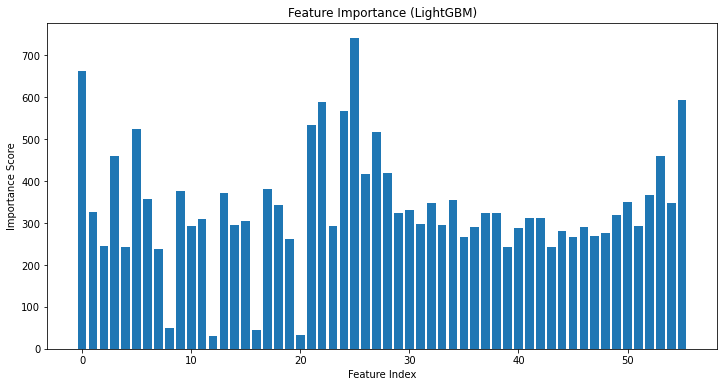

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Loading data...")
# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Split features and target
X = train_df.drop('label', axis=1)
y = train_df['label']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Preprocessing data...")
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_df)

# Function to add physics-inspired features
def add_physics_features(X):
    X_new = X.copy()
    
    # Calculate radial distance for pairs of features
    for i in range(0, X.shape[1], 2):
        if i + 1 < X.shape[1]:
            radial = np.sqrt(X[:, i]**2 + X[:, i+1]**2)
            X_new = np.column_stack((X_new, radial))
            
            angle = np.arctan2(X[:, i+1], X[:, i])
            X_new = np.column_stack((X_new, angle))
    
    return X_new

# Apply feature engineering
X_train_fe = add_physics_features(X_train_scaled)
X_val_fe = add_physics_features(X_val_scaled)
X_test_fe = add_physics_features(X_test_scaled)

# Drop highly correlated features (above 0.95 correlation)
X_train_fe_df = pd.DataFrame(X_train_fe)
corr_matrix = X_train_fe_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_train_fe_df.drop(to_drop, axis=1, inplace=True)
X_train_fe = X_train_fe_df.values

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_train_fe = selector.fit_transform(X_train_fe)
X_val_fe = selector.transform(X_val_fe)
X_test_fe = selector.transform(X_test_fe)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"After feature engineering: {X_train_fe.shape[1]}")

print("Training models...")
# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42
)
xgb_model.fit(X_train_fe, y_train)

# Train LightGBM model with fixed hyperparameters
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,  # More trees
    learning_rate=0.05,  # Lower learning rate
    max_depth=10,  # Deeper trees
    num_leaves=64,  # More leaves for splits
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1]),  # Handle class imbalance
    random_state=42
)
lgb_model.fit(X_train_fe, y_train)

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train_fe, y_train)

print("Evaluating models...")
# Evaluate on validation set
xgb_preds = xgb_model.predict_proba(X_val_fe)[:, 1]
lgb_preds = lgb_model.predict_proba(X_val_fe)[:, 1]
gb_preds = gb_model.predict_proba(X_val_fe)[:, 1]

xgb_auc = roc_auc_score(y_val, xgb_preds)
lgb_auc = roc_auc_score(y_val, lgb_preds)
gb_auc = roc_auc_score(y_val, gb_preds)

print(f"XGBoost AUC: {xgb_auc:.5f}")
print(f"LightGBM AUC: {lgb_auc:.5f}")
print(f"Gradient Boosting AUC: {gb_auc:.5f}")

# Example data
y = np.array([1, 1, 2, 2])
pred = np.array([0.1, 0.4, 0.35, 0.8])

# Compute ROC curve and AUROC
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
print(metrics.auc(fpr, tpr))

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("Creating ensemble predictions...")
# Create a weighted ensemble
xgb_weight = 0.4
lgb_weight = 0.4
gb_weight = 0.2

xgb_test_preds = xgb_model.predict_proba(X_test_fe)[:, 1]
lgb_test_preds = lgb_model.predict_proba(X_test_fe)[:, 1]
gb_test_preds = gb_model.predict_proba(X_test_fe)[:, 1]

ensemble_preds = (xgb_test_preds * xgb_weight + 
                 lgb_test_preds * lgb_weight + 
                 gb_test_preds * gb_weight)

print("Creating submission file...")
# Convert Id column to string type
ids = [str(i) for i in range(len(ensemble_preds))]  # Ensure Id is a string

# Convert predictions to string type
ensemble_preds_str = [str(pred) for pred in ensemble_preds]

# Combine Ids and predictions into a structured array
submission_array = np.column_stack((ids, ensemble_preds_str))

# Save submission file in correct format
np.savetxt(
    fname="sample_submission.csv",
    X=submission_array,
    header="Id,Predicted",
    delimiter=",",
    comments='',
    fmt="%s"  # Use '%s' to write both Ids and predictions as strings
)

print("Submission file created successfully!")

# Verify submission file
print("\nFirst 5 lines of submission file:")
with open("sample_submission.csv", "r") as f:
    for i in range(5):
        print(f.readline().strip())

# Plot feature importance for LightGBM
print("Plotting feature importances...")
importances = lgb_model.feature_importances_
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance (LightGBM)")
plt.show()

### Converting the Original Output


In [ ]:
# Checking the data type of the 'Id' column
# Read the CSV file called 'sample_submission.csv'
df = pd.read_csv('sample_submission.csv')

# Check data types of all columns
print(df.dtypes)
# =============================================================================
# Convert 'Id' column to string
df['Id'] = df['Id'].astype('string')

# Verify the new data type
print(df['Id'].dtype)  # Should now show 'object' (pandas' way of representing string)

df.to_csv('sample_submission.csv', index=False)

Id             int64
Predicted    float64
dtype: object
string


### Converting the Copy Output

In [50]:
# Checking the data type of the 'Id' column
# Read the CSV file called 'sample_submission_copy.csv'
df_1 = pd.read_csv('sample_submission_copy.csv')


In [ ]:
# Check data types of all columns
print(df_1.dtypes)

Id             int64
Predicted    float64
dtype: object


In [52]:
# Convert 'Id' column to string
df_1['Id'] = df_1['Id'].astype('string')

In [53]:
# Verify the new data type
print(df_1['Id'].dtype)  # Should now show 'object' (pandas' way of representing string)

df_1.to_csv('sample_submission_fixed.csv', index=False)

string
